## IPCC Scenario Cross-Analysis

### 0. Libraries

In [60]:
# Import useful libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 1. Initialization and Loading

In [42]:
# set up some variables
scenarios = ['126', '245', '370', '585']
anomaly_percent = 99
season = 'summer_'
n_memb = 1

In [43]:
# number of days in each season 
# e.g. winter = January + February + March = 90 days
season_sizes = {
    "winter_": 90,
    "spring_": 91,
    "summer_": 92,
    "autumn_": 92,
    "": 365
}
season_size = season_sizes[season]

In [44]:
### Load data

# past
train_loss = pd.read_csv(f"../outputs/train_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
test_loss = pd.read_csv(f"../outputs/test_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]

# projections
proj126_loss = pd.read_csv(f"../outputs/proj126_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
proj245_loss = pd.read_csv(f"../outputs/proj245_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
proj370_loss = pd.read_csv(f"../outputs/proj370_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
proj585_loss = pd.read_csv(f"../outputs/proj585_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]

# time tracks
train_time = pd.read_csv(f"../input/dates_train_{season}data_{n_memb}memb.csv")
test_time = pd.read_csv(f"../input/dates_test_{season}data_{n_memb}memb.csv")
proj_time = pd.read_csv(f"../input/dates_proj_{season}data_{n_memb}memb.csv")

In [45]:
# handle time
train_time.columns = ['index', 'time']
start_year = int(train_time.iloc[0,1][:4])
total_time = len(train_time)+len(test_time) + len(proj_time)

### 2. Data Insight

In [46]:
# creation of a recapitulative dataframe with all time series
recap_df = pd.DataFrame(index = range(total_time),
                        columns = ['train', 'test', 'ssp126',
                                   'ssp245', 'ssp370', 'ssp585'],
                       dtype=float)

recap_df.iloc[:len(train_time),0] = np.array(train_loss)
recap_df.iloc[len(train_time):len(train_time)+len(test_time),1] = np.array(test_loss)

recap_df.iloc[total_time-len(proj_time):total_time,2] = np.array(proj126_loss)
recap_df.iloc[total_time-len(proj_time):total_time,3] = np.array(proj245_loss)
recap_df.iloc[total_time-len(proj_time):total_time,4] = np.array(proj370_loss)
recap_df.iloc[total_time-len(proj_time):total_time,5] = np.array(proj585_loss)

In [47]:
# creation of a yearly dataset for easier visualization
recap_df['avg_group'] = np.array([i//season_size for i in range(len(recap_df))])
avg_recap = recap_df.groupby(['avg_group']).mean()
avg_recap.index = range(start_year,start_year+len(avg_recap))
avg_recap.tail()

,train,test,ssp126,ssp245,ssp370,ssp585
2096,NaN,NaN,0.002143,0.002274,0.003394,0.003391
2097,NaN,NaN,0.001896,0.002148,0.003216,0.003620
2098,NaN,NaN,0.001578,0.001487,0.001666,0.003870
2099,NaN,NaN,0.002204,0.001540,0.003525,0.004037
2100,NaN,NaN,0.001196,0.002534,0.003573,0.003238


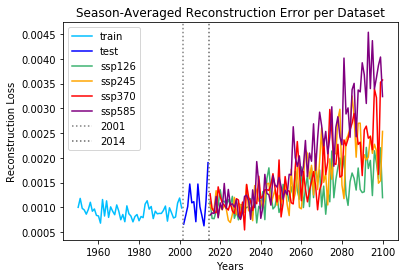

In [48]:
# Plot all scenarios on the same chart for a quick comparison
colors = ['deepskyblue', 'blue', 'mediumseagreen', 'orange', 'red', 'purple']
for i in range(len(avg_recap.columns)):
    plt.plot(avg_recap.iloc[:,i], color = colors[i])
train_end = start_year + int(len(train_loss)/season_size)
test_end = start_year + int((len(train_loss)+len(test_loss))/season_size)
plt.axvline(x = train_end-0.5, color = 'grey', ls = ':', label = '2001')
plt.axvline(x = test_end-0.5, color = 'dimgrey', ls = ':', label = '2014')
legend = list(avg_recap.columns)
legend.append('2001')
legend.append('2014')
plt.legend(legend)
plt.title('Season-Averaged Reconstruction Error per Dataset')
plt.ylabel('Reconstruction Loss')
plt.xlabel('Years')
#plt.savefig(f'outputs/{season}avg_ssp_errors.png', transparent=True)
plt.show()

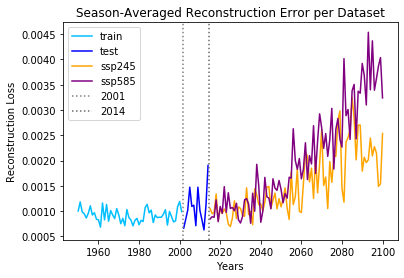

In [49]:
# Keep only the most studied scenarios: SSP2-4.5 and SSP5-8.5
colors = ['deepskyblue', 'blue', 'orange', 'purple']
for i in range(avg_recap.iloc[:, [0,1,3,5]].shape[1]):
    plt.plot(avg_recap.iloc[:, [0,1,3,5]].iloc[:,i], color = colors[i])
train_end = start_year + int(len(train_loss)/season_size)
test_end = start_year + int((len(train_loss)+len(test_loss))/season_size)
plt.axvline(x = train_end-0.5, color = 'grey', ls = ':', label = '2001')
plt.axvline(x = test_end-0.5, color = 'dimgrey', ls = ':', label = '2014')
legend = list(avg_recap.columns[[0,1,3,5]])
legend.append('2001')
legend.append('2014')
plt.legend(legend)
plt.title('Season-Averaged Reconstruction Error per Dataset')
plt.ylabel('Reconstruction Loss')
plt.xlabel('Years')
plt.show()

### 3. Rare Event Analysis

In [50]:
anomaly_table = pd.DataFrame(index = ['unusual_days', 'day_proportion',
                                      'max_spike', 'avg_max_spike',
                                      'max_duration', 'avg_duration',
                                      'number_of_spikes'
                                     ],
                        columns = ['test', 'ssp126',
                                   'ssp245', 'ssp370', 'ssp585'])

#### a) Number of Abnormal Days

In [51]:
# get the value of 99-percentile over the test period
past_threshold = np.percentile(test_loss, anomaly_percent)
anomaly_day = 100*sum(test_loss>past_threshold)/len(test_loss)
print(f'Over the historical test dataset, {round(anomaly_day, 2)}', 
      '% of the days resulted in a higher reconstruction error than', 
      f'{round(past_threshold, 4)}.')
anomaly_table.loc['day_proportion', 'test'] = anomaly_day

Over the historical test dataset, 1.0 % of the days resulted in a higher reconstruction error than 0.0033.


In [52]:
# check the number of days above the threshold for various scenarios
anomaly_days = []
proj_loss = [proj126_loss, proj245_loss, proj370_loss, proj585_loss]
for i in range(len(scenarios)):
    anomaly_day = 100*sum(proj_loss[i]>past_threshold)/len(proj_loss[i])
    anomaly_days.append(anomaly_day)
    print(f'Over SSP{scenarios[i]} projections,', 
          f'{round(anomaly_day, 2)}% of days', 
          'had an unusually high reconstruction error.')
    anomaly_table.loc['day_proportion', f'ssp{scenarios[i]}'] = anomaly_day

Over SSP126 projections, 4.55% of days had an unusually high reconstruction error.
Over SSP245 projections, 8.92% of days had an unusually high reconstruction error.
Over SSP370 projections, 11.12% of days had an unusually high reconstruction error.
Over SSP585 projections, 19.24% of days had an unusually high reconstruction error.


#### b) Number of Spikes

In [53]:
def spike_statistics(test_loss, proj_loss, anomaly_percent=99):
    past_threshold = np.percentile(test_loss, anomaly_percent)
    spike_starts = []
    spike_ends = []
    spike_max = []
    spike_avg = []
    spike_values = []
    values = []
    # initialize i=0
    if proj_loss[0]>past_threshold:
        spike_starts.append(0)
    for i in range(1, len(proj_loss)):
        if proj_loss[i]>past_threshold:
            # spike start
            if proj_loss[i-1]<=past_threshold:
                spike_starts.append(i)
            # current spike
            spike_values.append(proj_loss[i])
        # spike end
        if proj_loss[i]<=past_threshold and proj_loss[i-1]>past_threshold:
            spike_ends.append(i-1)
            spike_max.append(max(spike_values))
            spike_avg.append(np.mean(spike_values))
            # store values of the ending spike and reset
            values.append(spike_values)
            spike_values = []
    if len(spike_starts) != len(spike_ends):
        spike_ends.append(i)
    spike_statistics = [spike_starts, spike_ends, spike_max, spike_avg]
    return spike_statistics, values   

In [54]:
spike_stat, values = spike_statistics(test_loss, proj126_loss, anomaly_percent)

In [55]:
spike_values = []
spike_maxima = []
spike_durations = []

# history
spike_stat, values = spike_statistics(test_loss, test_loss)
spike_max = spike_stat[2]
spike_duration = np.array(spike_stat[1]) + 1 - np.array(spike_stat[0])

spike_values.append(np.concatenate(values))
spike_durations.append(spike_duration)
spike_maxima.append(spike_max)

anomaly_table.loc['unusual_days', 'test'] = sum(spike_duration)
anomaly_table.loc['max_spike', 'test'] = max(spike_max)
anomaly_table.loc['avg_max_spike', 'test'] = np.mean(spike_max)
anomaly_table.loc['max_duration', 'test'] = max(spike_duration)
anomaly_table.loc['avg_duration', 'test'] = np.mean(spike_duration)
anomaly_table.loc['number_of_spikes', 'test'] = len(spike_max)

# projections
for i in range(len(scenarios)):
    scenario = scenarios[i]
    spike_stat, values = spike_statistics(test_loss, proj_loss[i])
    spike_max = spike_stat[2]
    spike_duration = np.array(spike_stat[1]) + 1 - np.array(spike_stat[0])

    spike_values.append(np.concatenate(values))
    spike_durations.append(spike_duration)
    spike_maxima.append(spike_max)
    
    anomaly_table.loc['unusual_days', f'ssp{scenarios[i]}'] = sum(spike_duration)
    anomaly_table.loc['max_spike', f'ssp{scenarios[i]}'] = max(spike_max)
    anomaly_table.loc['avg_max_spike', f'ssp{scenarios[i]}'] = np.mean(spike_max)
    anomaly_table.loc['max_duration', f'ssp{scenarios[i]}'] = max(spike_duration)
    anomaly_table.loc['avg_duration', f'ssp{scenarios[i]}'] = np.mean(spike_duration)
    anomaly_table.loc['number_of_spikes', f'ssp{scenarios[i]}'] = len(spike_max)


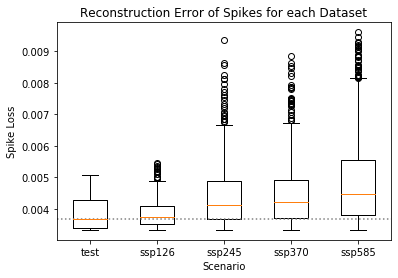

In [56]:
# moustache chart with spike values
plt.boxplot(spike_values)
plt.xticks([1,2,3,4,5], ['test', 'ssp126', 'ssp245', 
                         'ssp370', 'ssp585'])
plt.axhline(y = np.median(spike_values[0]), color = 'grey', ls = ':', label = '2001')
plt.title('Reconstruction Error of Spikes for each Dataset')
plt.ylabel('Spike Loss')
plt.xlabel('Scenario')
#plt.savefig(f'outputs/{season}spike_values_ssp_errors_boxplot.png', transparent=True)
plt.show()

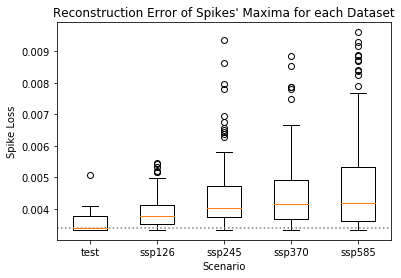

In [57]:
# moustache chart with max spike values
plt.boxplot(spike_maxima)
plt.xticks([1,2,3,4,5], ['test', 'ssp126', 'ssp245', 
                         'ssp370', 'ssp585'])
plt.axhline(y = np.median(spike_maxima[0]), color = 'grey', ls = ':', label = '2001')
plt.title("Reconstruction Error of Spikes' Maxima for each Dataset")
plt.ylabel('Spike Loss')
plt.xlabel('Scenario')
#plt.savefig(f'outputs/{season}max_spike_ssp_errors_boxplot.png', transparent=True)
plt.show()

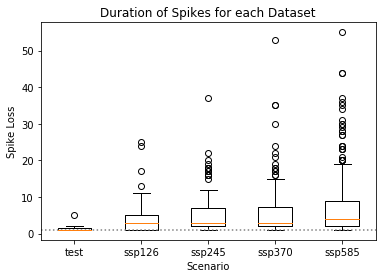

In [58]:
# moustache chart with max spike values
plt.boxplot(spike_durations)
plt.xticks([1,2,3,4,5], ['test', 'ssp126', 'ssp245', 
                         'ssp370', 'ssp585'])
plt.axhline(y = np.median(spike_durations[0]), color = 'grey', ls = ':', label = '2001')
plt.title('Duration of Spikes for each Dataset')
plt.ylabel('Spike Loss')
plt.xlabel('Scenario')
#plt.savefig(f'outputs/{season}spike_duration_ssp_errors_boxplot.png', transparent=True)
plt.show()

In [59]:
anomaly_table

,test,ssp126,ssp245,ssp370,ssp585
unusual_days,12,360,706,880,1522
day_proportion,1.00334,4.55005,8.92315,11.1223,19.2366
max_spike,0.00508369,0.00545038,0.0093406,0.00883803,0.00959728
avg_max_spike,0.00372029,0.00392768,0.00441384,0.00450589,0.00469531
max_duration,5,25,37,53,55
avg_duration,1.71429,3.87097,5.47287,6.28571,7.96859
number_of_spikes,7,93,129,140,191


### 4. All Seasons

In [61]:
# creation of a recapitulative dataframe with all time series
all_seasons = pd.DataFrame(columns = ['time', 'train', 'test', 'ssp126',
                                   'ssp245', 'ssp370', 'ssp585'])

for season in ['winter_', 'spring_', 'summer_', 'autumn_']:
    
    # past
    train_loss = pd.read_csv(f"../outputs/train_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
    test_loss = pd.read_csv(f"../outputs/test_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]

    # projections
    proj126_loss = pd.read_csv(f"../outputs/proj126_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
    proj245_loss = pd.read_csv(f"../outputs/proj245_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
    proj370_loss = pd.read_csv(f"../outputs/proj370_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]
    proj585_loss = pd.read_csv(f"../outputs/proj585_losses_{season}1d_{n_memb}memb.csv").iloc[:,1]

    # time tracks
    train_time = pd.read_csv(f"../input/dates_train_{season}data_{n_memb}memb.csv")
    test_time = pd.read_csv(f"../input/dates_test_{season}data_{n_memb}memb.csv")
    proj_time = pd.read_csv(f"../input/dates_proj_{season}data_{n_memb}memb.csv")

    total_time = len(train_time)+len(test_time) + len(proj_time)
    
    temp_seasons = pd.DataFrame(index = range(total_time),
                        columns = ['time', 'train', 'test', 'ssp126',
                                   'ssp245', 'ssp370', 'ssp585'],
                               dtype=float)

    temp_seasons.iloc[:len(train_time),0] = train_time.iloc[:,1]
    temp_seasons.iloc[len(train_time):len(train_time)+len(test_time),0] = np.array(test_time.iloc[:,1])
    temp_seasons.iloc[total_time-len(proj_time):total_time,0] = np.array(proj_time.iloc[:,1])

    temp_seasons.iloc[:len(train_time),1] = train_loss
    temp_seasons.iloc[len(train_time):len(train_time)+len(test_time),2] = np.array(test_loss)

    temp_seasons.iloc[total_time-len(proj_time):total_time,3] = np.array(proj126_loss)
    temp_seasons.iloc[total_time-len(proj_time):total_time,4] = np.array(proj245_loss)
    temp_seasons.iloc[total_time-len(proj_time):total_time,5] = np.array(proj370_loss)
    temp_seasons.iloc[total_time-len(proj_time):total_time,6] = np.array(proj585_loss)

    all_seasons = pd.concat([all_seasons, temp_seasons])

# sort by time
all_seasons = all_seasons.sort_values(by=['time'])
all_seasons = all_seasons.reset_index(drop=True)

In [62]:
# creation of a less noisy dataset for visualization
start_year = int(all_seasons.iloc[0,0][:4])
all_seasons['avg_group'] = np.array([start_year+i//365 for i in range(len(all_seasons))])
all_years = all_seasons.groupby(['avg_group']).mean()
all_years.iloc[[50, 51, 53, 64, 65, 66],:]

,train,test,ssp126,ssp245,ssp370,ssp585
avg_group,,,,,,
2000,0.001462,NaN,NaN,NaN,NaN,NaN
2001,0.001045,NaN,NaN,NaN,NaN,NaN
2003,NaN,0.000972,NaN,NaN,NaN,NaN
2014,NaN,0.001562,NaN,NaN,NaN,NaN
2015,NaN,NaN,0.001070,0.000977,0.001266,0.000992
2016,NaN,NaN,0.000865,0.000894,0.001101,0.001176


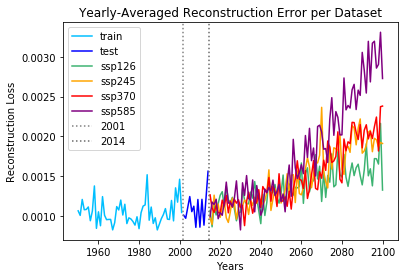

In [63]:
# Plot all scenarios on the same chart for a quick comparison
colors = ['deepskyblue', 'blue', 'mediumseagreen', 'orange', 'red', 'purple']
for i in range(avg_recap.shape[1]):
    plt.plot(all_years.iloc[:,i], color = colors[i])
train_end = start_year + int(len(train_loss)/season_size)
test_end = start_year + int((len(train_loss)+len(test_loss))/season_size)
plt.axvline(x = train_end-0.5, color = 'grey', ls = ':', label = '2001')
plt.axvline(x = test_end-0.5, color = 'dimgrey', ls = ':', label = '2014')
legend = list(avg_recap.columns)
legend.append('2001')
legend.append('2014')
plt.legend(legend)
plt.title('Yearly-Averaged Reconstruction Error per Dataset')
plt.ylabel('Reconstruction Loss')
plt.xlabel('Years')
#plt.savefig(f'outputs/yearly_avg_ssp_errors.png', transparent=True)
plt.show()

In [64]:
#train_all = all_seasons.loc[all_seasons.loc[:,'train'].notna(),'train']
test_all = np.array(all_seasons.loc[all_seasons.loc[:,'test'].notna(),'test'])

proj126_all = np.array(all_seasons.loc[all_seasons.loc[:,'ssp126'].notna(),'ssp126'])
proj245_all = np.array(all_seasons.loc[all_seasons.loc[:,'ssp245'].notna(),'ssp245'])
proj370_all = np.array(all_seasons.loc[all_seasons.loc[:,'ssp370'].notna(),'ssp370'])
proj585_all = np.array(all_seasons.loc[all_seasons.loc[:,'ssp585'].notna(),'ssp585'])

In [65]:
anomaly_table = pd.DataFrame(index = ['unusual_days', 'day_proportion',
                                      'max_spike', 'avg_max_spike',
                                      'max_duration', 'avg_duration'
                                     ],
                        columns = ['test', 'ssp126',
                                   'ssp245', 'ssp370', 'ssp585'])

# get the value of 99-percentile over the test period
past_threshold = np.percentile(test_all, anomaly_percent)
anomaly_day = 100*sum(test_all>past_threshold)/len(test_all)
print(f'Over the historical test dataset, {round(anomaly_day, 2)}', 
      '% of the days resulted in a higher reconstruction error than', 
      f'{round(past_threshold, 4)}.')
anomaly_table.loc['day_proportion', 'test'] = anomaly_day

Over the historical test dataset, 1.01 % of the days resulted in a higher reconstruction error than 0.0038.


In [66]:
# check the number of days above the threshold for various scenarios
anomaly_days = []
proj_all = [proj126_all, proj245_all, proj370_all, proj585_all]
for i in range(len(scenarios)):
    anomaly_day = 100*sum(proj_all[i]>past_threshold)/len(proj_all[i])
    anomaly_days.append(anomaly_day)
    print(f'Over SSP{scenarios[i]} projections,', 
          f'{round(anomaly_day, 2)}% of days', 
          'had an unusually high reconstruction error.')
    anomaly_table.loc['day_proportion', f'ssp{scenarios[i]}'] = anomaly_day


Over SSP126 projections, 5.42% of days had an unusually high reconstruction error.
Over SSP245 projections, 7.45% of days had an unusually high reconstruction error.
Over SSP370 projections, 7.56% of days had an unusually high reconstruction error.
Over SSP585 projections, 11.73% of days had an unusually high reconstruction error.


In [67]:
spike_values = []
spike_maxima = []
spike_durations = []

# history
spike_stat, values = spike_statistics(test_all, test_all)
spike_max = spike_stat[2]
spike_duration = np.array(spike_stat[1]) + 1 - np.array(spike_stat[0])

spike_values.append(np.concatenate(values).flat)
spike_durations.append(spike_duration)
spike_maxima.append(spike_max)

anomaly_table.loc['unusual_days', 'test'] = len(spike_max)
anomaly_table.loc['max_spike', 'test'] = max(spike_max)
anomaly_table.loc['avg_max_spike', 'test'] = np.mean(spike_max)
anomaly_table.loc['max_duration', 'test'] = max(spike_duration)
anomaly_table.loc['avg_duration', 'test'] = np.mean(spike_duration)

In [68]:
# projections
for i in range(len(scenarios)):
    scenario = scenarios[i]
    spike_stat, values = spike_statistics(test_all, proj_all[i])
    spike_max = spike_stat[2]
    spike_duration = np.array(spike_stat[1]) + 1 - np.array(spike_stat[0])

    spike_values.append(np.concatenate(values).flat)
    spike_durations.append(spike_duration)
    spike_maxima.append(spike_max)
    
    anomaly_table.loc['unusual_days', f'ssp{scenarios[i]}'] = len(spike_max)
    anomaly_table.loc['max_spike', f'ssp{scenarios[i]}'] = max(spike_max)
    anomaly_table.loc['avg_max_spike', f'ssp{scenarios[i]}'] = np.mean(spike_max)
    anomaly_table.loc['max_duration', f'ssp{scenarios[i]}'] = max(spike_duration)
    anomaly_table.loc['avg_duration', f'ssp{scenarios[i]}'] = np.mean(spike_duration)

In [69]:
anomaly_table

,test,ssp126,ssp245,ssp370,ssp585
unusual_days,14,348,435,382,506
day_proportion,1.01159,5.42211,7.44823,7.55655,11.7267
max_spike,0.00801438,0.0133101,0.0110235,0.011386,0.0159493
avg_max_spike,0.00500383,0.00502677,0.00513106,0.00527138,0.00557068
max_duration,8,32,33,34,54
avg_duration,3.42857,4.8908,5.37471,6.20942,7.2747


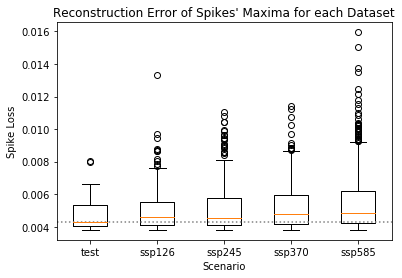

In [70]:
# moustache chart with max spike values
plt.boxplot(spike_maxima)
plt.xticks([1,2,3,4,5], ['test', 'ssp126', 'ssp245', 
                         'ssp370', 'ssp585'])
plt.axhline(y = np.median(spike_maxima[0]), color = 'grey', ls = ':', label = '2001')
plt.title("Reconstruction Error of Spikes' Maxima for each Dataset")
plt.ylabel('Spike Loss')
plt.xlabel('Scenario')
#plt.savefig(f'outputs/yearly_max_spike_ssp_errors_boxplot.png', transparent=True)
plt.show()

In [71]:
all_losses = [test_all, proj126_all, proj245_all, proj370_all, proj585_all]

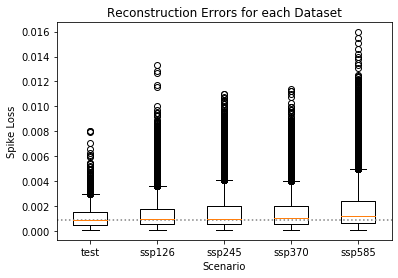

In [72]:
# moustache chart with error values
plt.boxplot(all_losses)
plt.xticks([1,2,3,4,5], ['test', 'ssp126', 'ssp245', 
                         'ssp370', 'ssp585'])
plt.axhline(y = np.median(all_losses[0]), color = 'grey', ls = ':', label = '2001')
plt.title("Reconstruction Errors for each Dataset")
plt.ylabel('Spike Loss')
plt.xlabel('Scenario')
#plt.savefig(f'outputs/yearly_all_errors_boxplot.png', transparent=True)
plt.show()

### 5. Time Series and Threshold Analysis

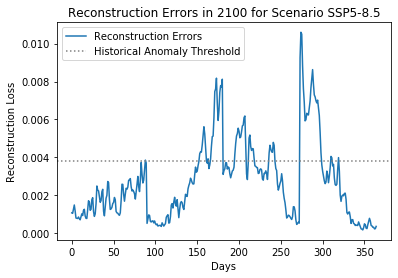

In [73]:
# Visualize the number of events in a year
plt.plot(proj585_all[-365:])
plt.axhline(y = past_threshold, color = 'grey', ls = ':', label = '2001')
plt.title('Reconstruction Errors in 2100 for Scenario SSP5-8.5')
legend = list(['Reconstruction Errors'])
legend.append('Historical Anomaly Threshold')
plt.legend(legend)
plt.ylabel('Reconstruction Loss')
plt.xlabel('Days')
plt.show()